### <h1><center><font color='orange'><b>Computer Vision Exercise 2<font></a>

In [1]:
!pip install rawpy

In [2]:
import numpy as np
import rawpy
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mig
import glob
import os

In [3]:
def visualize_image(image, title="Image", cmap='gray'):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.colorbar(label=title)
    plt.show()

In [4]:
#raw_image = np.load('/kaggle/input/ex2-dataset/exercise_2_data/01/IMG_9939.npy')
#jpg_image = mig.imread('/kaggle/input/ex2-dataset/exercise_2_data/01/IMG_9939.JPG')
raw_image = np.load('exercise_2_data/01/IMG_9939.npy')
jpg_image = mig.imread('exercise_2_data/01/IMG_9939.JPG')
raw_image.shape

(4014, 6020)

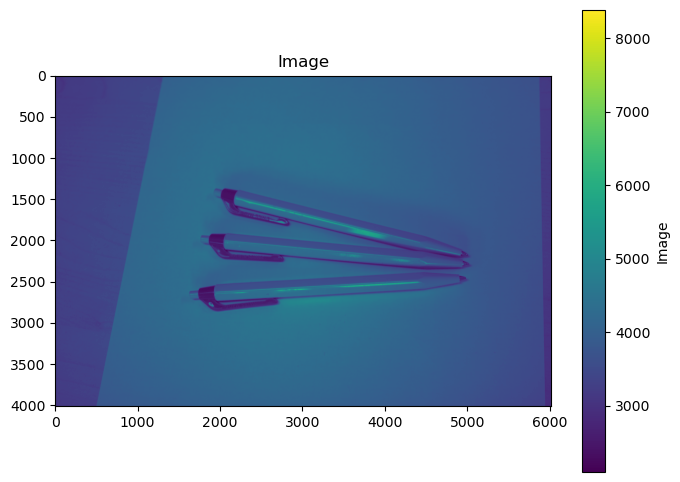

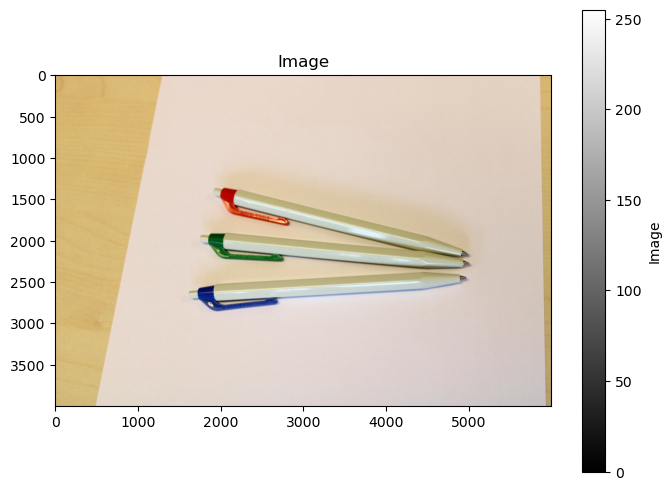

In [5]:
visualize_image(raw_image, cmap='viridis')
visualize_image(jpg_image)

# Task 1: Investigating Bayer Patterns

In [6]:
#Shape of the raw data for context
print("Raw data shape:", raw_image.shape)


# Display: 4x4 block to help identify the pattern
block_size = 4
sample_block = raw_image[:block_size, :block_size]

# Print out the sample block
print("Sample 4x4 block for inspection:")
print(sample_block)

# Examine values across positions in 2x2 blocks to determine the Bayer pattern
print("\nIndividual values in 2x2 blocks for potential pattern identification:")

print("Position (0,0):", raw_image[0, 0])  
print("Position (0,1):", raw_image[0, 1])  
print("Position (1,0):", raw_image[1, 0])  
print("Position (1,1):", raw_image[1, 1])  

print("\nCheck a few more 2x2 blocks for confirmation:")
for i in range(0, block_size, 2):
    for j in range(0, block_size, 2):
        print(f"Block starting at ({i},{j}):")
        print(f"  ({i},{j}):", raw_image[i, j])
        print(f"  ({i},{j+1}):", raw_image[i, j+1])
        print(f"  ({i+1},{j}):", raw_image[i+1, j])
        print(f"  ({i+1},{j+1}):", raw_image[i+1, j+1])


Raw data shape: (4014, 6020)
Sample 4x4 block for inspection:
[[3361 2596 3352 2614]
 [2829 3371 2854 3405]
 [3382 2614 3380 2608]
 [2833 3370 2894 3374]]

Individual values in 2x2 blocks for potential pattern identification:
Position (0,0): 3361
Position (0,1): 2596
Position (1,0): 2829
Position (1,1): 3371

Check a few more 2x2 blocks for confirmation:
Block starting at (0,0):
  (0,0): 3361
  (0,1): 2596
  (1,0): 2829
  (1,1): 3371
Block starting at (0,2):
  (0,2): 3352
  (0,3): 2614
  (1,2): 2854
  (1,3): 3405
Block starting at (2,0):
  (2,0): 3382
  (2,1): 2614
  (3,0): 2833
  (3,1): 3370
Block starting at (2,2):
  (2,2): 3380
  (2,3): 2608
  (3,2): 2894
  (3,3): 3374


Green pixels generally have higher intensity values than red or blue pixels. This is because the human eye is more sensitive to green, and most Bayer patterns (such as RGGB) have more green pixels than red or blue.

The values at positions like (0,0) and (1,1) are generally higher, suggesting they might correspond to green pixels.
The positions (0,1) and (1,0) tend to have lower values compared to their neighboring pixels. In typical Bayer patterns, these could represent red and blue pixels.

This suggests a GRBG pattern:

Top row (0,0) and (0,1):
(0,0): Green (higher values, e.g., 3361, 3352)
(0,1): Red (lower values, e.g., 2596, 2614)

Bottom row (1,0) and (1,1):
(1,0): Blue (lower values, e.g., 2829, 2854)
(1,1): Green (higher values, e.g., 3371, 3405)
The structure seems to repeat consistently across blocks, supporting the interpretation of a GRBG Bayer pattern.


# Task 2: Implementation of Demosaicing Algorithm

In [7]:
def demosaic_bilinear(raw_image, bayer_pattern='RGGB'):
    padded_image = np.pad(raw_image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    height, width = padded_image.shape
    red_channel = np.zeros((height, width))
    green_channel = np.zeros((height, width))
    blue_channel = np.zeros((height, width))

    if bayer_pattern == 'RGGB':
        # Assign known values
        
        red_channel[1:-1:2, 1:-1:2] = padded_image[1:-1:2, 1:-1:2]
        green_channel[1:-1:2, 2:-1:2] = padded_image[1:-1:2, 2:-1:2]
        green_channel[2:-1:2, 1:-1:2] = padded_image[2:-1:2, 1:-1:2]
        blue_channel[2:-1:2, 2:-1:2] = padded_image[2:-1:2, 2:-1:2]
        
        red_channel[2:-1:2, 1:-1:2] = (padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2] +
                                       padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2]) / 4
        red_channel[1:-1:2, 2:-1:2] = (padded_image[0:-2:2, 2:-1:2] + padded_image[2::2, 2:-1:2] +
                                       padded_image[1:-1:2, 1:-2:2] + padded_image[1:-1:2, 3::2]) / 4
        red_channel[2:-1:2, 2:-1:2] = (padded_image[1:-2:2, 1:-2:2] + padded_image[1:-2:2, 3::2] +
                                       padded_image[3::2, 1:-2:2] + padded_image[3::2, 3::2]) / 4

        green_channel[1:-1:2, 1:-1:2] = (padded_image[1:-1:2, 0:-2:2] + padded_image[1:-1:2, 2::2] +
                                         padded_image[0:-2:2, 1:-1:2] + padded_image[2::2, 1:-1:2]) / 4
        green_channel[2:-1:2, 2:-1:2] = (padded_image[2:-1:2, 1:-2:2] + padded_image[2:-1:2, 3::2] +
                                         padded_image[1:-2:2, 2:-1:2] + padded_image[3::2, 2:-1:2]) / 4

        blue_channel[1:-1:2, 2:-1:2] = (padded_image[0:-2:2, 2:-1:2] + padded_image[2::2, 2:-1:2] +
                                        padded_image[1:-1:2, 1:-2:2] + padded_image[1:-1:2, 3::2]) / 4
        blue_channel[2:-1:2, 1:-1:2] = (padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2] +
                                        padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2]) / 4
        blue_channel[1:-1:2, 1:-1:2] = (padded_image[0:-2:2, 0:-2:2] + padded_image[0:-2:2, 2::2] +
                                        padded_image[2::2, 0:-2:2] + padded_image[2::2, 2::2]) / 4

    elif bayer_pattern == 'GRBG':
        green_channel[1:-1:2, 1:-1:2] = padded_image[1:-1:2, 1:-1:2]
        red_channel[1:-1:2, 2:-1:2] = padded_image[1:-1:2, 2:-1:2]
        blue_channel[2:-1:2, 1:-1:2] = padded_image[2:-1:2, 1:-1:2]
        green_channel[2:-1:2, 2:-1:2] = padded_image[2:-1:2, 2:-1:2]
        
        red_channel[2:-1:2, 1:-1:2] = (padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2] +
                                       padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2]) / 4
        red_channel[1:-1:2, 1:-1:2] = (padded_image[0:-2:2, 1:-1:2] + padded_image[2::2, 1:-1:2] +
                                       padded_image[1:-1:2, 0:-2:2] + padded_image[1:-1:2, 2::2]) / 4
        red_channel[2:-1:2, 2:-1:2] = (padded_image[1:-2:2, 2:-1:2] + padded_image[3::2, 2:-1:2] +
                                       padded_image[2:-1:2, 1:-2:2] + padded_image[2:-1:2, 3::2]) / 4

        green_channel[1:-1:2, 2:-1:2] = (padded_image[1:-1:2, 1:-1:2] + padded_image[1:-1:2, 3::2] +
                                         padded_image[0:-2:2, 2:-1:2] + padded_image[2::2, 2:-1:2]) / 4
        green_channel[2:-1:2, 1:-1:2] = (padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2] +
                                         padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2]) / 4

        blue_channel[1:-1:2, 1:-1:2] = (padded_image[0:-2:2, 1:-1:2] + padded_image[2::2, 1:-1:2] +
                                        padded_image[1:-1:2, 0:-2:2] + padded_image[1:-1:2, 2::2]) / 4
        blue_channel[2:-1:2, 2:-1:2] = (padded_image[1:-2:2, 2:-1:2] + padded_image[3::2, 2:-1:2] +
                                        padded_image[2:-1:2, 1:-2:2] + padded_image[2:-1:2, 3::2]) / 4
        
    elif bayer_pattern == 'BGGR':
        blue_channel[1:-1:2, 1:-1:2] = padded_image[1:-1:2, 1:-1:2]
        green_channel[1:-1:2, 2:-1:2] = padded_image[1:-1:2, 2:-1:2]
        green_channel[2:-1:2, 1:-1:2] = padded_image[2:-1:2, 1:-1:2]
        red_channel[2:-1:2, 2:-1:2] = padded_image[2:-1:2, 2:-1:2]
        
        blue_channel[1:-1:2, 2:-1:2] = (padded_image[1:-1:2, 1:-2:2] + padded_image[1:-1:2, 3::2] +
                                        padded_image[0:-2:2, 2:-1:2] + padded_image[2::2, 2:-1:2]) / 4
        blue_channel[2:-1:2, 1:-1:2] = (padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2] +
                                        padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2]) / 4
        blue_channel[2:-1:2, 2:-1:2] = (padded_image[1:-2:2, 1:-2:2] + padded_image[1:-2:2, 3::2] +
                                        padded_image[3::2, 1:-2:2] + padded_image[3::2, 3::2]) / 4

        green_channel[1:-1:2, 1:-1:2] = (padded_image[0:-2:2, 1:-1:2] + padded_image[2::2, 1:-1:2] +
                                         padded_image[1:-1:2, 0:-2:2] + padded_image[1:-1:2, 2::2]) / 4
        green_channel[2:-1:2, 2:-1:2] = (padded_image[2:-1:2, 1:-2:2] + padded_image[2:-1:2, 3::2] +
                                         padded_image[1:-2:2, 2:-1:2] + padded_image[3::2, 2:-1:2]) / 4

        red_channel[1:-1:2, 1:-1:2] = (padded_image[0:-2:2, 0:-2:2] + padded_image[0:-2:2, 2::2] +
                                       padded_image[2::2, 0:-2:2] + padded_image[2::2, 2::2]) / 4
        red_channel[2:-1:2, 1:-1:2] = (padded_image[1:-2:2, 1:-1:2] + padded_image[3::2, 1:-1:2] +
                                       padded_image[2:-1:2, 0:-2:2] + padded_image[2:-1:2, 2::2]) / 4
        red_channel[1:-1:2, 2:-1:2] = (padded_image[0:-2:2, 2:-1:2] + padded_image[2::2, 2:-1:2] +
                                       padded_image[1:-1:2, 1:-2:2] + padded_image[1:-1:2, 3::2]) / 4

    else:
        raise ValueError('Unknown Bayer Pattern')
    rgb_image = np.stack((red_channel[1:-1, 1:-1], green_channel[1:-1, 1:-1], blue_channel[1:-1, 1:-1]), axis=-1)
    return rgb_image


In [8]:
def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    image = (image - min_val) / (max_val - min_val) * 255
    image = np.round(image).astype(np.uint8)
    return image

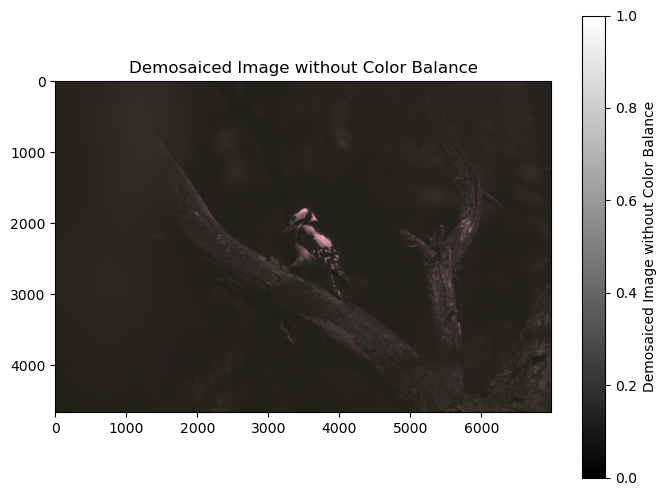

In [9]:
#with rawpy.imread('/kaggle/input/ex2-dataset/exercise_2_data/03/IMG_4782.CR3') as raw:
with rawpy.imread('exercise_2_data/03/IMG_4782.CR3') as raw:
    raw_image = np.array(raw.raw_image_visible)

demosaiced_image = demosaic_bilinear(raw_image, bayer_pattern='GRBG')
# Display the result
normalized_image = demosaiced_image / np.max(demosaiced_image)  # Normalized for display
visualize_image(normalized_image, title = "Demosaiced Image without Color Balance")

# Task 3: Improving Luminosity

In [10]:
def apply_gamma_correction(image, gamma=0.3):
    a = np.percentile(image, 0.01)
    b = np.percentile(image, 99.99)
    image_normalized = (image - a) / (b - a)
    image_normalized[image_normalized < 0] = 0
    image_normalized[image_normalized > 1] = 1

    print(image_normalized.min())

    image_gamma_corrected = image_normalized ** gamma

    image_corrected = image_gamma_corrected * (b - a) + a
    return image_corrected

In [11]:
def apply_log_correction(image, scale_factor=1.0):
    a = np.percentile(image, 0.01)
    b = np.percentile(image, 99.99)
    image_normalized = (image - a) / (b - a)
    image_normalized[image_normalized < 0] = 0
    image_normalized[image_normalized > 1] = 1

    image_log_corrected = np.log1p(image_normalized * scale_factor) / np.log1p(scale_factor)

    image_corrected = image_log_corrected * (b - a) + a
    return image_corrected

0.0


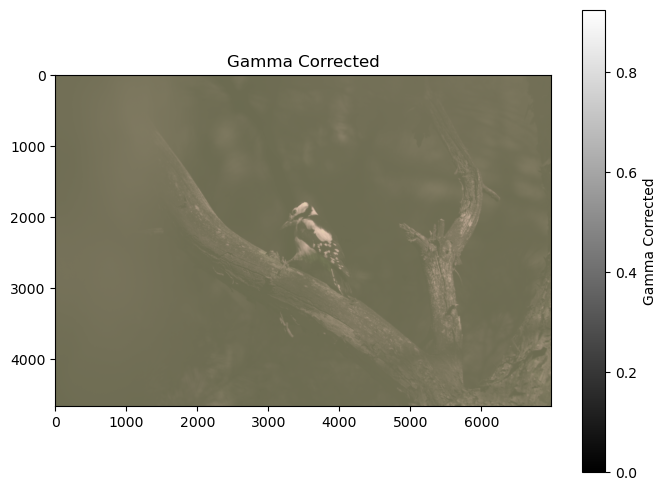

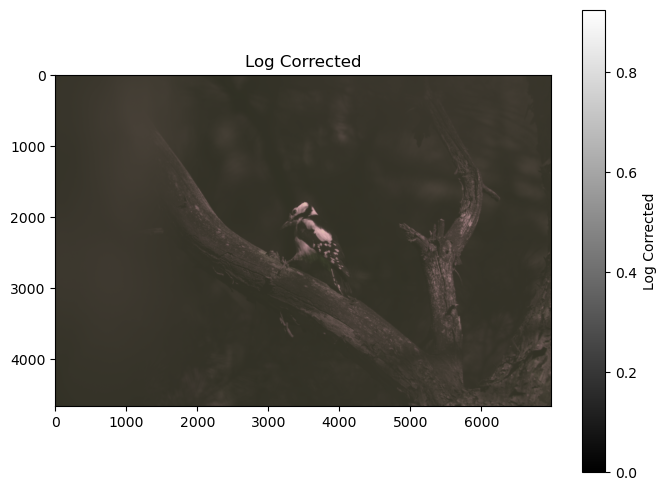

In [12]:
gamma_corrected_image = apply_gamma_correction(normalized_image, gamma=0.4)
log_corrected_image = apply_log_correction(normalized_image, scale_factor=1.5)

#gamma_corrected_image = normalize_image(gamma_corrected_image)
#log_corrected_image = normalize_image(log_corrected_image)

visualize_image(gamma_corrected_image, title='Gamma Corrected')
visualize_image(log_corrected_image, title='Log Corrected')


# Task 4: Grey World

In [13]:
def gray_world_white_balance(image):
    image_copy = np.copy(image)
    # Calculate the mean of each channel
    mean_red = np.mean(image[:, :, 0])
    mean_green = np.mean(image[:, :, 1])
    mean_blue = np.mean(image[:, :, 2])

    # Calculate the overall mean
    mean_gray = (mean_red + mean_green + mean_blue) / 3

    # Scale each channel to match the overall mean
    image_copy[:, :, 0] = image_copy[:, :, 0] * (mean_gray / mean_red)
    image_copy[:, :, 1] = image_copy[:, :, 1] * (mean_gray / mean_green)
    image_copy[:, :, 2] = image_copy[:, :, 2] * (mean_gray / mean_blue)

    # Clip values to be in the range [0, 255]
    image_copy = np.clip(image_copy, 0, 255)

    return image_copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


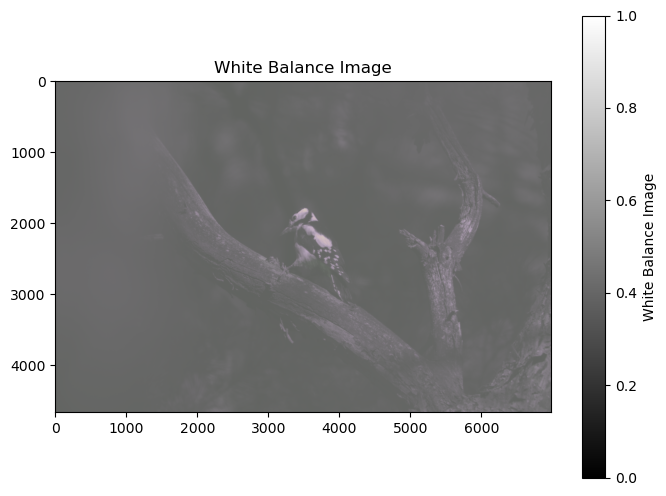

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


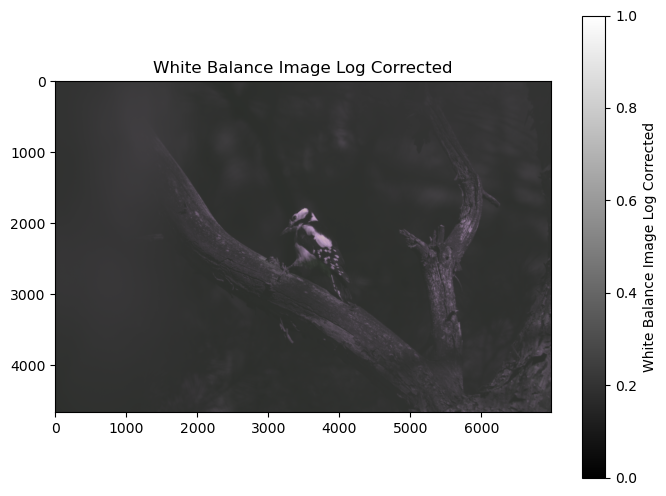

In [14]:
gray_world_corrected_image = gray_world_white_balance(gamma_corrected_image)
visualize_image(gray_world_corrected_image, 'White Balance Image')

log_corrected_white = gray_world_white_balance(log_corrected_image)
visualize_image(log_corrected_white, 'White Balance Image Log Corrected')

# Task 5: Verification of Linearity in Sensor Data

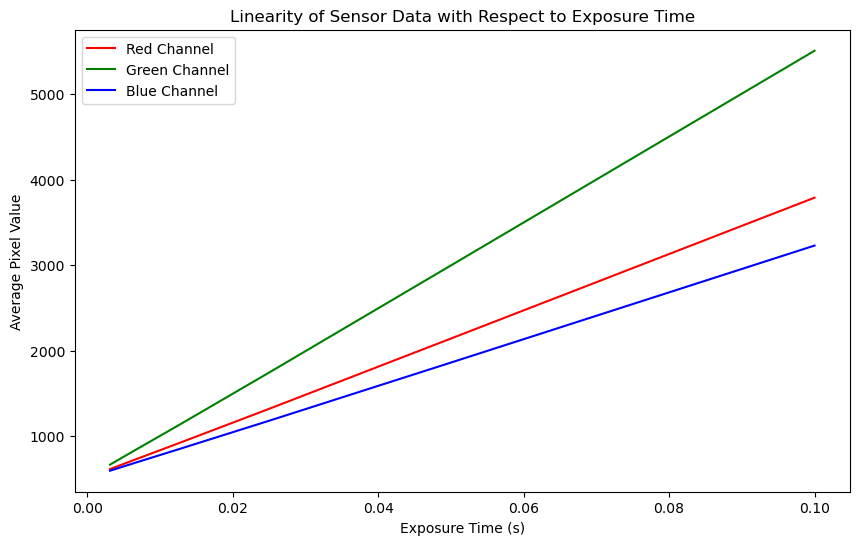

In [15]:
exposure_times = [1/10, 1/20, 1/40, 1/80, 1/160, 1/320]
image_files = ['IMG_3044.CR3', 'IMG_3045.CR3', 'IMG_3046.CR3', 'IMG_3047.CR3',
               'IMG_3048.CR3', 'IMG_3049.CR3']
# image_path = '/kaggle/input/ex2-dataset/exercise_2_data/02/<FILE_PLACEHOLDER>'
image_path = 'exercise_2_data/02/<FILE_PLACEHOLDER>'



avg_red = []
avg_green = []
avg_blue = []

for image_name in image_files:
    raw = rawpy.imread(image_path.replace('<FILE_PLACEHOLDER>', image_name))
    raw_image = np.array(raw.raw_image_visible)
    red_pixels = raw_image[::2, ::2]
    green_pixels_1 = raw_image[::2, 1::2]
    green_pixels_2 = raw_image[1::2, ::2]
    blue_pixels = raw_image[1::2, 1::2]

    avg_red.append(np.average(red_pixels))
    avg_blue.append(np.average(blue_pixels))
    avg_green.append((np.average(green_pixels_1) + np.average(green_pixels_1))/2)

plt.figure(figsize=(10, 6))
plt.plot(exposure_times, avg_red, 'r-', label='Red Channel')
plt.plot(exposure_times, avg_green, 'g-', label='Green Channel')
plt.plot(exposure_times, avg_blue, 'b-', label='Blue Channel')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Average Pixel Value')
plt.title('Linearity of Sensor Data with Respect to Exposure Time')
plt.legend()
plt.show()

With this graph, we can say that the sensor data is indeed linear

# Task 6: HDR Image Generation

In [16]:
raw = rawpy.imread('exercise_2_data/06/04.CR3')
h = np.array(raw.raw_image_visible)
sample_block = h[:4, :4]
sample_block

array([[682, 884, 657, 830],
       [838, 760, 839, 770],
       [650, 867, 677, 847],
       [841, 780, 853, 792]], dtype=uint16)

Upon observing the image, it suggests that the Bayer pattern in these images is **RGGB** instead of GRGB like in the other images

In [17]:
def load_and_scale_image(filepath, scale_factor):
    """
    Load a RAW image, scale it by the exposure factor, and return as an array.
    """
    with rawpy.imread(filepath) as raw:
        raw_image = np.array(raw.raw_image_visible)
        return raw_image * scale_factor



In [18]:
def combine_exposures(image_files, exposure_times):
    hdr_image = np.zeros_like(load_and_scale_image(image_files[0], 1.0))

    for i, filepath in enumerate(image_files):
        scale_factor = exposure_times[0] / exposure_times[i]
        scaled_image = load_and_scale_image(filepath, scale_factor)
        hdr_image += scaled_image  # Accumulate HDR data

    return hdr_image

In [19]:
def apply_gamma_correction(image, gamma=0.3):
    a = np.percentile(image, 0.01)
    b = np.percentile(image, 99.99)
    image_normalized = (image - a) / (b - a)
    image_normalized[image_normalized < 0] = 0
    image_normalized[image_normalized > 1] = 1

    print(image_normalized.min())

    image_gamma_corrected = image_normalized ** gamma

    image_corrected = image_gamma_corrected * (b - a) + a
    return image_corrected

In [20]:
def compress_dynamic_range(hdr_image):
    hdr_log = np.log1p(hdr_image)  # log(1 + x) to avoid log(0)
    
    hdr_normalized = 255 * (hdr_log - np.min(hdr_log)) / (np.max(hdr_log) - np.min(hdr_log))
    hdr_normalized = np.clip(hdr_normalized, 0, 255)
    
    return hdr_normalized.astype(np.uint8)



0.0


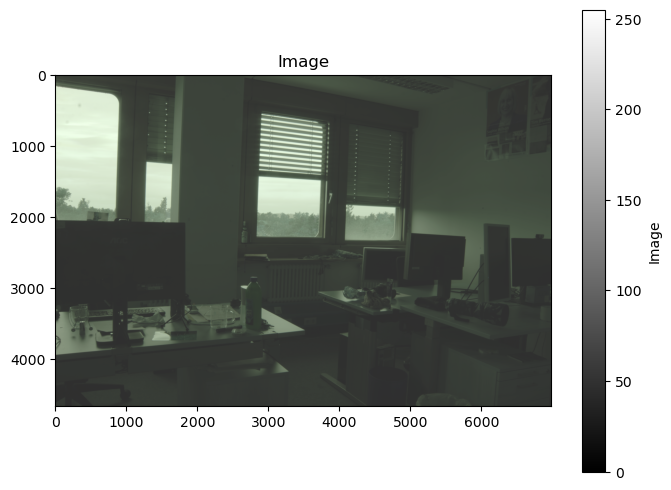

In [21]:
image_files = sorted(glob.glob('exercise_2_data/06/*.CR3'))
exposure_times = [1 / (1.5**i) for i in range(len(image_files))]  # Exposure times halving for each image


hdr_image = combine_exposures(image_files, exposure_times)
demosaiced_hdr_image = demosaic_bilinear(hdr_image, bayer_pattern='BGGR')

# hdr_image = normalize_image(demosaiced_hdr_image)
# white_balanced_hdr_image = gray_world_white_balance(hdr_image)
compressed_hdr_image = compress_dynamic_range(demosaiced_hdr_image)
gamma = apply_gamma_correction(compressed_hdr_image, gamma = 0.9)
white_balanced_hdr_image = gray_world_white_balance(gamma)
gamma = normalize_image(gamma)
cv.imwrite('HDR_image_result.png', compressed_hdr_image)
visualize_image(gamma)

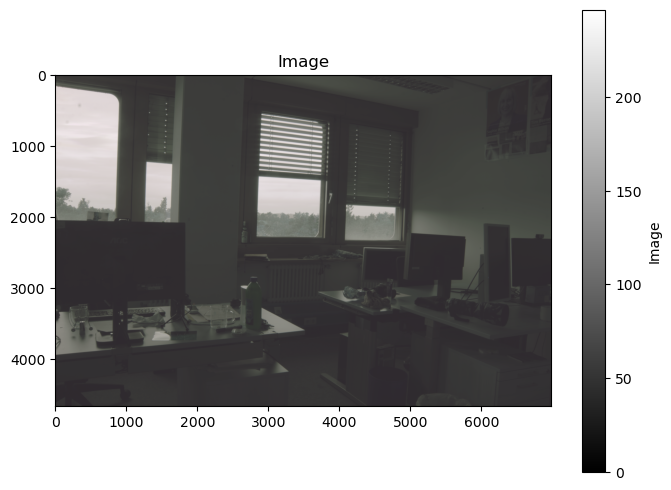

In [22]:
def dampen_green(image, damping_factor=0.7):
    b, g, r = cv.split(image)
    g = cv.multiply(g, damping_factor)
    corrected_image = cv.merge([b, g, r])
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image

im = dampen_green(gamma, damping_factor = 0.9)
visualize_image(im)

# Task 7:  iCAM06

In [36]:
def apply_icam06_tonemapping(hdr_image):
    hdr_image = np.float32(hdr_image) / 255.0

    output_range = 4.0  # Output range for tonemapping

    input_intensity = (1 / 61) * (20 * hdr_image[..., 0] + 40 * hdr_image[..., 1] + hdr_image[..., 2])

    input_intensity = np.maximum(input_intensity, 1e-8)

    r = hdr_image[..., 0] / input_intensity
    g = hdr_image[..., 1] / input_intensity
    b = hdr_image[..., 2] / input_intensity

    log_input_intensity = np.log(input_intensity).astype(np.float32)

    log_base = cv.bilateralFilter(log_input_intensity, d=3, sigmaColor=75, sigmaSpace=75)

    log_details = log_input_intensity - log_base

    compression = np.log(output_range) / (np.max(log_base) - np.min(log_base))

    log_offset = -np.max(log_base) * compression

    output_intensity = np.exp(log_base * compression + log_offset + log_details)

    r_out = r * output_intensity
    g_out = g * output_intensity
    b_out = b * output_intensity

    tonemapped_image = np.stack([r_out, g_out, b_out], axis=-1)
    tonemapped_image = np.clip(tonemapped_image, 0, 1)

    return tonemapped_image

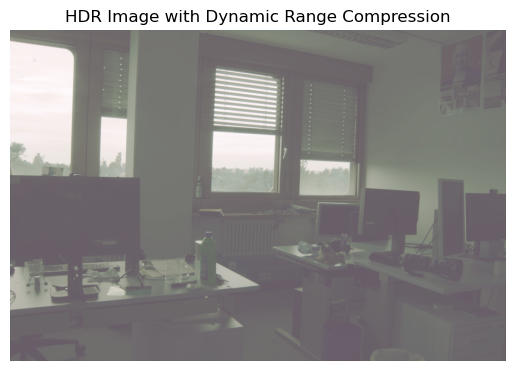

In [44]:
tonemapped_hdr_image = apply_icam06_tonemapping(im)


plt.imshow(tonemapped_hdr_image, cmap='gray')
plt.title("HDR Image with Dynamic Range Compression")
plt.axis('off')
plt.show()

# TASK 8: Win

In [26]:
import rawpy
import cv2 as cv
import numpy as np

def process_raw(input_path, output_path):
    try:
        with rawpy.imread(input_path) as raw:
            rgb_image = raw.postprocess(use_camera_wb=True, no_auto_bright=True, output_bps=8)
    except Exception as e:
        print(f"Error reading the input file: {e}")
        return

    rgb_image = cv.fastNlMeansDenoisingColored(rgb_image, None, 10, 10, 7, 21)
    lab_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv.split(lab_image)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    lab_image = cv.merge((l_channel, a_channel, b_channel))
    rgb_image = cv.cvtColor(lab_image, cv.COLOR_LAB2RGB)
    hsv_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_image)
    s = cv.equalizeHist(s)
    hsv_image = cv.merge((h, s, v))
    rgb_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2RGB)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    rgb_image = cv.filter2D(rgb_image, -1, kernel)
    cv.imwrite(output_path, cv.cvtColor(rgb_image, cv.COLOR_RGB2BGR))
    print(f"Processed image saved to: {output_path}")

In [27]:
process_raw('exercise_2_data/03/IMG_4782.CR3', 'finaltasksubmitted.jpg')

Processed image saved to: finaltasksubmitted.jpg
